In [1]:
library(ggplot2)
library(boot)
library(glue)
library(dplyr)
library(tidyr)
library(janitor)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'janitor'


The following objects are masked from 'package:stats':

    chisq.test, fisher.test




In [2]:
# Đường dẫn tới file hiện tại
base_path <- getwd()
setwd(base_path)
set.seed(23)
options(warn = -1) # Bỏ qua warning

In [3]:
# Dùng các hàm từ functions.R
source("functions.R")

## BÀI TẬP 1

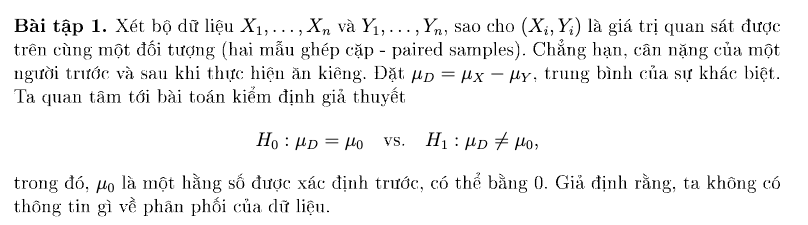

- a. Thiết lập quy trình kiểm đinh bootstrap cho giả thuyết H0 được nhắc tới ở trên

Ghéo 2 mẫu X, Y thành một (mẫu gộp)
- 1. Tạo ra một mẫu ngẫu nhiên Z* (cùng với cỡ dữ liệu gốc) từ dữ liệu gốc có lặp lại
- 2. Từ mẫu boostrap ta ấn đinh:
    - n1 giá trị đầu là mẫu bootstrap của X
    - n - n1 giá trị tiếp theo là mẫu boostrap của Y
- 3. Ước lượng X* trung bình, Sx*^2, Y* trung bình và Sy*^2 từ dữ liệu vừa tạo
- 4. Tính giá trị thống kê:
    t* = X* trung bình - Y* trung bình
    hoặc
    $$t^* = \frac{\left(\overline{X}^* - \overline{Y}^*\right)}{S_p^* \sqrt{\frac{1}{n_1} + \frac{1}{n_2}}}$$
- 5. Lặp lại bước 1, 2, 3 và 4 trong B lần (ít nhất 2000 lần), và lưu kết quả lại
- 6. Tính p-value theo công thức:
$$p\text{-value} = \frac{1}{B} \sum_{j=1}^{B} \mathbb{I}\left( \left| t_j^* \right| \geq \left| t_{\text{obs}} \right| \right),
$$
với:
$$t_{\text{obs}} = \overline{X} - \overline{Y}, \quad \text{hoặc} \quad t_{\text{obs}} = \frac{\left(\overline{X} - \overline{Y}\right)}{S_p \sqrt{\frac{1}{n_1} + \frac{1}{n_2}}}.
$$

In [4]:
# Tạo mẫu:
n = 60
# X: trước và sau khi giảm cân:
X_Y = runif(n, min = 45, max = 65)
df <- data.frame(value = X_Y,
type = factor(rep(c("before", "after"), each = 30))
)
head(df)
tail(df)

,value,type
,<dbl>,<fct>
1,56.53207,before
2,49.46146,before
3,51.63793,before
4,59.21449,before
5,61.38898,before
6,53.47441,before


,value,type
,<dbl>,<fct>
55,62.86083,after
56,45.39431,after
57,50.08880,after
58,64.03891,after
59,56.32334,after
60,62.95164,after


In [5]:
df |> group_by(type) |>
summarise(n = n(), mean = mean(value), sd = sd(value))

type,n,mean,sd
<fct>,<int>,<dbl>,<dbl>
after,30,55.62703,5.926967
before,30,57.18695,5.509389


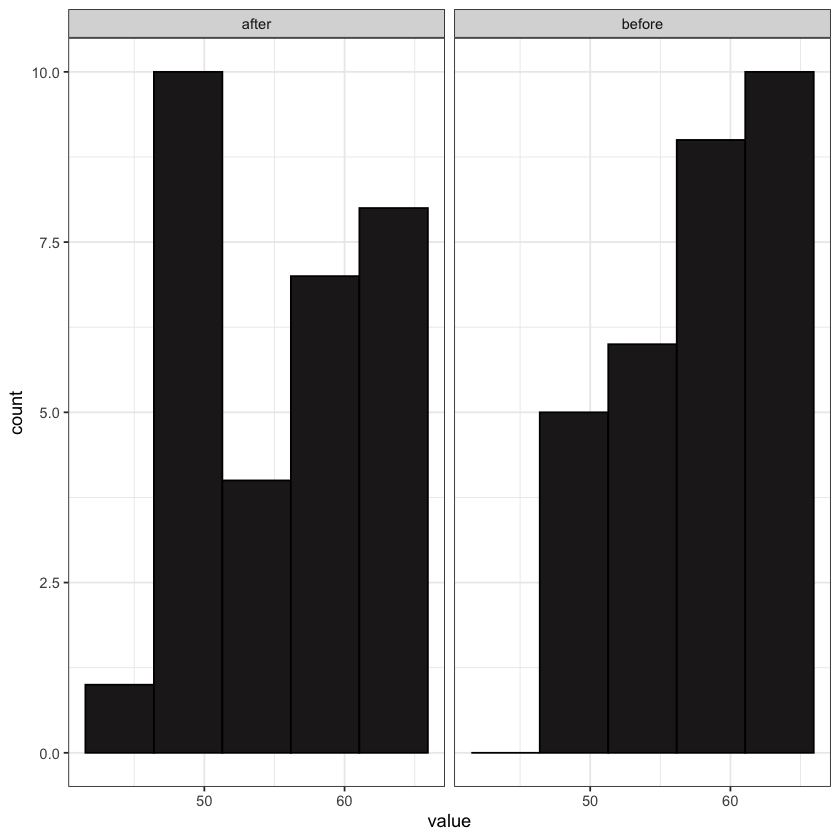

In [6]:
ggplot(df, mapping = aes(x = value)) +
geom_histogram(bins = 5, fill = "#221f1f", color = "black") +
facet_grid(~ type) +
theme_bw()

In [7]:
# Rõ ràng giả định phân phối chuẩn cho hai nhóm dữ liệu là không thể hợp lý.
#Tỷ số độ lệch chuẩn của hai nhóm là:
sd(df$value[df$type == "before"])/
sd(df$value[df$type == "after"])

[1] 0.929546

- Tỷ số độ lệch chuẩn của hai nhóm là nằm trong khoảng từ (0.5, 2). Do đó, giả định về đồng phương sai là hợp lý

- Ta áp dụng bootstrap test cho kiểm định trung bình. Đầu tiên, ta định nghĩa hàm tính thống kê kiểm định theo hiệu số để thực hiện bootstrap

In [8]:
two_mean_test_diff_eqv <- function(data, ind, n1, n2){
data <- data[ind]
x <- data[1:n1]
y <- data[(n1 + 1):length(data)]
t_stat <- mean(x) - mean(y)
return(t_stat)
}

In [9]:
t_obs <- two_mean_test_diff_eqv(df$value,
c(1:nrow(df)), n1 = 30, n2 = 30)
t_obs

[1] 1.559923

In [10]:
out_boot <- boot(data = df$value,
statistic = two_mean_test_diff_eqv, R = 10000,
n1 = 30, n2 = 30)
out_boot


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = df$value, statistic = two_mean_test_diff_eqv, R = 10000, 
    n1 = 30, n2 = 30)


Bootstrap Statistics :
    original    bias    std. error
t1* 1.559923 -1.549173    1.468414

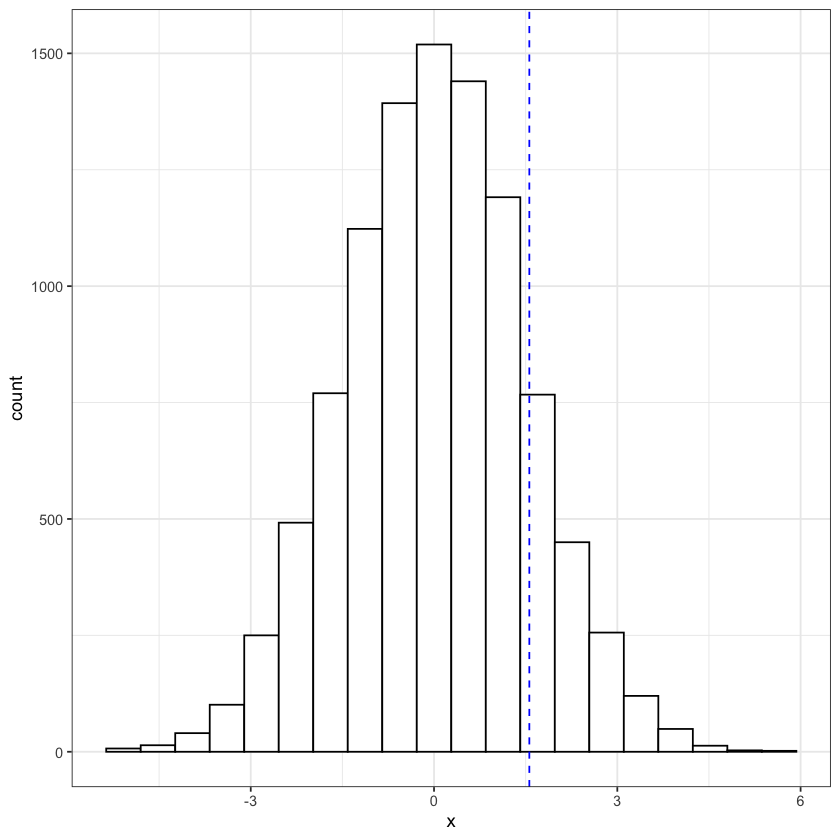

In [11]:
ggplot(data = data.frame(x = out_boot$t), mapping = aes(x = x)) +
geom_histogram(bins = 20, fill = "white", color = "black") +
geom_vline(xintercept = t_obs, linetype = "dashed", color = "blue") +
theme_bw()

In [12]:
p_value = mean((out_boot$t) > abs(t_obs))
p_value

[1] 0.14

- Ta thu được kết quả p-value = 0.14 >  alpha = 0.05.
Vì vậy ta chưa đủ bằng chứng để bác bỏ giả thuyết H0 rằng trung bình cân nặng trước và sau giảm cân là như nhau.


- b. Thực hiện mô phỏng Monte Carlo để kiểm độ chính xác của quy trình vừa được thiết lập trong câu a. Tức là ước tính xác suất thực nghiệm sai lầm loại I (trong kịch bản H0 là sự thực đúng) và ước lượng độ mạnh thực nghiệm - power (trong kịch bản H0 là thực sự sai), với các cỡ mẫu thay đổi từ nhỏ tới lớn. So sánh kết quả với kiểm định t-test cho mẫu ghép cặp

## BÀI TẬP 2

In [13]:
df = read_csv_function(base_path = base_path, file_name = "Walleye.csv")
head(df)

,Length,Weight
,<dbl>,<dbl>
1,11.1,0.40
2,16.1,1.39
3,20.7,2.80
4,14.3,1.03
5,11.5,0.50
6,15.7,0.90


- a.Tạo biểu đồ và biểu đồ QQ plot của dữ liệu và mô tả sự phân bố

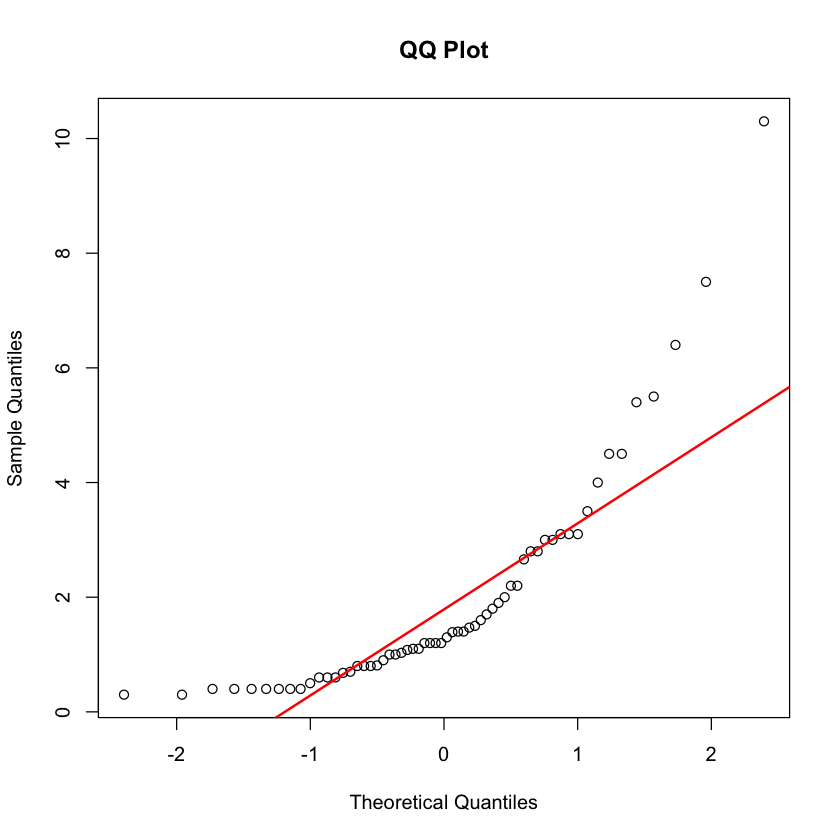

In [14]:
qqnorm(df$Weight, main = "QQ Plot")
qqline(df$Weight, col = "red", lwd = 2)

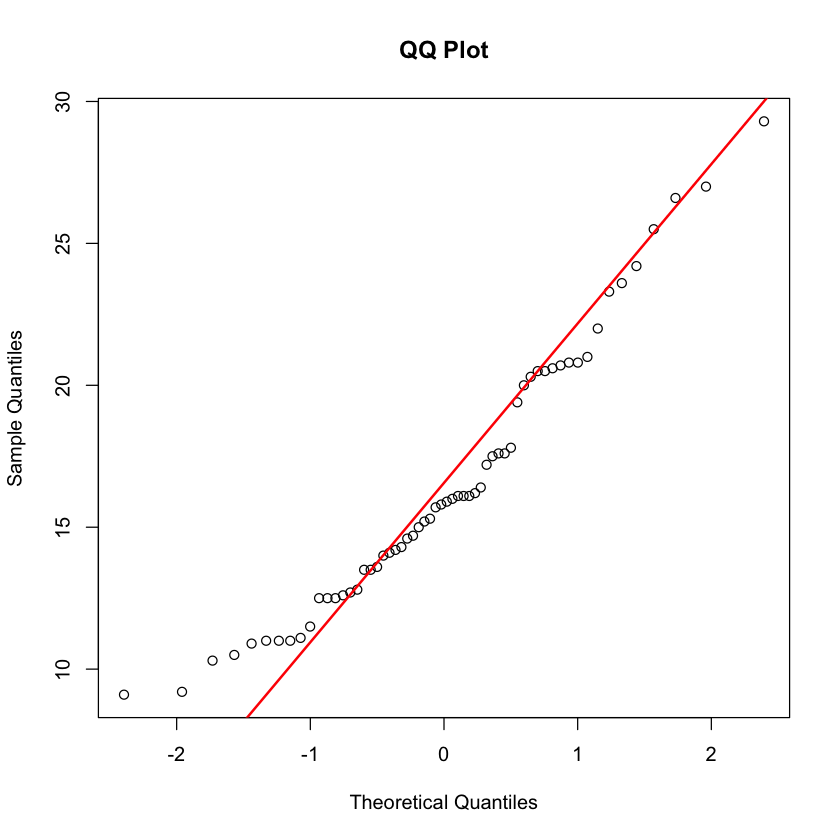

In [15]:
qqnorm(df$Length, main = "QQ Plot")
qqline(df$Length, col = "red", lwd = 2)

- Với biểu đồ QQ plot của Lenght ta thấy:
    - Các điểm dữ liệu không nằm hoàn toàn trên đường thẳng 45 độ, đặc biệt là ở phần đầu và phần cuối. Điều này cho thấy dữ liệu có sự lệch lạc và không tuân theo phân phối chuẩn.
    -  Các điểm dữ liệu ở khu vực giữa có xu hướng gần với đường thẳng, cho thấy phần giữa của phân phối có thể gần với phân phối chuẩn hơn, nhưng vẫn có một số sai lệch.



In [16]:
# Thực hiện kiểm định K-S cho cột Weight
ks_test_Weight <- ks.test(df$Weight, "pnorm", mean=mean(df$Weight), sd=sd(df$Weight))

# Hiển thị kết quả kiểm định
print(ks_test_Weight)


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  df$Weight
D = 0.19965, p-value = 0.01674
alternative hypothesis: two-sided



- Với p-value = 0.01674, chúng ta có thể bác bỏ giả thuyết không rằng cột Weight của DataFrame df tuân theo phân phối chuẩn ở mức ý nghĩa 0.05. Điều này có nghĩa là dữ liệu cột Weight có khác biệt đáng kể so với phân phối chuẩn

In [17]:
# Thực hiện kiểm định K-S cho cột Length
ks_test_Length <- ks.test(df$Length, "pnorm", mean=mean(df$Length), sd=sd(df$Length))

# Hiển thị kết quả kiểm định
print(ks_test_Length)


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  df$Length
D = 0.1271, p-value = 0.287
alternative hypothesis: two-sided



- Với p-value = 0.287, chúng ta không có đủ bằng chứng để bác bỏ giả thuyết không rằng cột Length của DataFrame df tuân theo phân phối chuẩn ở mức ý nghĩa 0.05. Điều này có nghĩa là dữ liệu không khác biệt đáng kể so với phân phối chuẩn

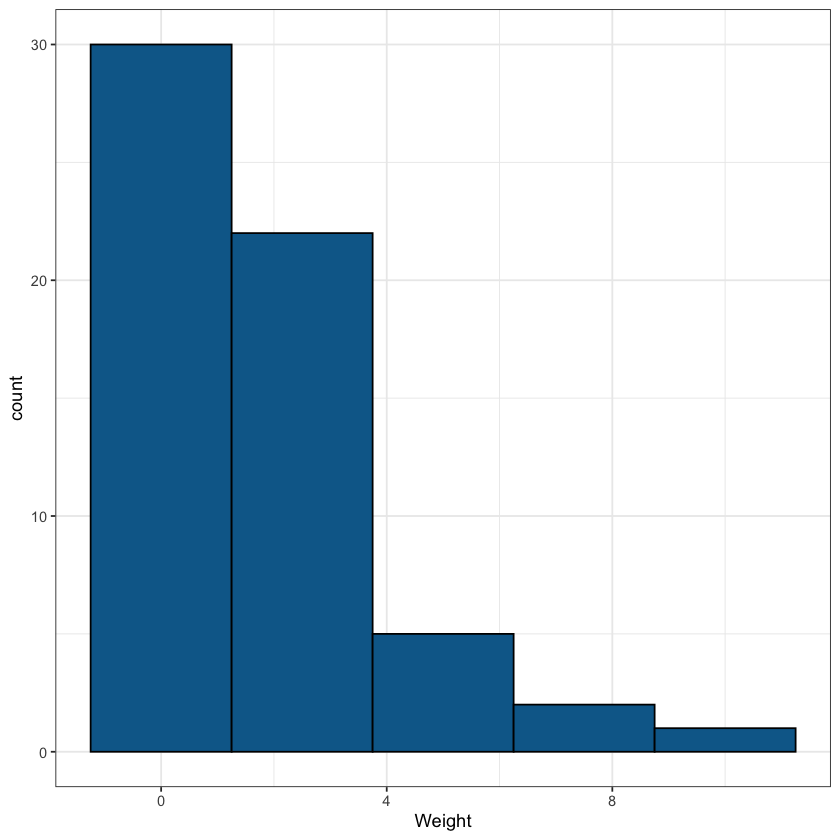

In [18]:
ggplot(df, mapping = aes(x = Weight)) +
geom_histogram(bins = 5, fill = "#0a6998", color = "black") +
theme_bw()

In [19]:
one_mean_test_diff <- function(data, ind, mu_0){
data <- data[ind]
t_stat <- mean(data) - mu_0
return(t_stat)
}

In [20]:
mu_0 = 2.5
t_obs <- one_mean_test_diff(data = df$Weight,
ind = c(1:12), mu_0 = mu_0)
t_obs

[1] -0.765

In [21]:
mean <- mean(df$Weight)
out_boot <- boot(data = df$Weight,
statistic = one_mean_test_diff, R = 10000,
mu_0 = mean)
out_boot


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = df$Weight, statistic = one_mean_test_diff, R = 10000, 
    mu_0 = mean)


Bootstrap Statistics :
    original      bias    std. error
t1*        0 0.003192617   0.2483765

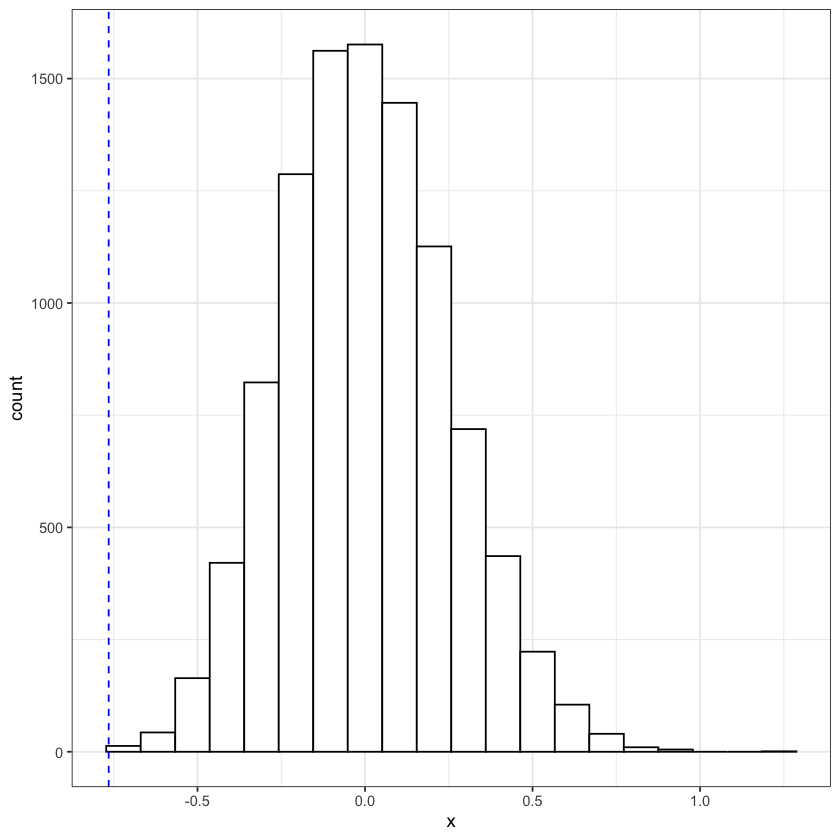

In [22]:
ggplot(data = data.frame(x = out_boot$t), mapping = aes(x = x)) +
geom_histogram(bins = 20, fill = "white", color = "black") +
geom_vline(xintercept = t_obs, linetype = "dashed", color = "blue") +
theme_bw()

In [23]:
p_value = mean(abs(out_boot$t) > abs(t_obs))
p_value

[1] 0.0016

- Với p-value = 0.0025 < mức ý nghĩa alpha = 0.05, ta có bằng chứng để bác bỏ H0 rằng khối lượng cá walleye = 2.5lb, có nghĩa là có sự khác biệt về trung bình của trọng lượng cá so với mức trung bình 2.5lb

In [24]:
# Thực hiện kiểm định t-test một mẫu
t_test_result <- t.test(df$Weight, mu = 2.5)  # Kiểm định trung bình có khác 2.5 hay không

# Hiển thị kết quả kiểm định
print(t_test_result)


	One Sample t-test

data:  df$Weight
t = -2.0462, df = 59, p-value = 0.0452
alternative hypothesis: true mean is not equal to 2.5
95 percent confidence interval:
 1.488625 2.488708
sample estimates:
mean of x 
 1.988667 



- Giá trị p-value là 0.0452, nhỏ hơn mức ý nghĩa 0.05. Điều này có nghĩa là có đủ bằng chứng để bác bỏ giả thuyết H0 rằng trung bình của cột Weight bằng 2.5.
- Kết quả của kiểm định bootstrap và t-test là giống nhau (đều bác bỏ H0 rằng trung bình của cột Weight = 2.5bl)

## BÀI TẬP 3

In [25]:
df = read_csv_function(base_path = base_path, file_name = "Nasdaq.csv")
head(df)

,Symbol,Open,Close,Volume
,<chr>,<dbl>,<dbl>,<int>
1,LQDT,5.75,5.80,58900
2,FEUZ,43.55,43.45,5400
3,PRIM,28.00,27.89,206600
4,OMED,4.84,4.90,202100
5,AGND,43.34,43.29,100400
6,WEBK,27.80,27.90,2200


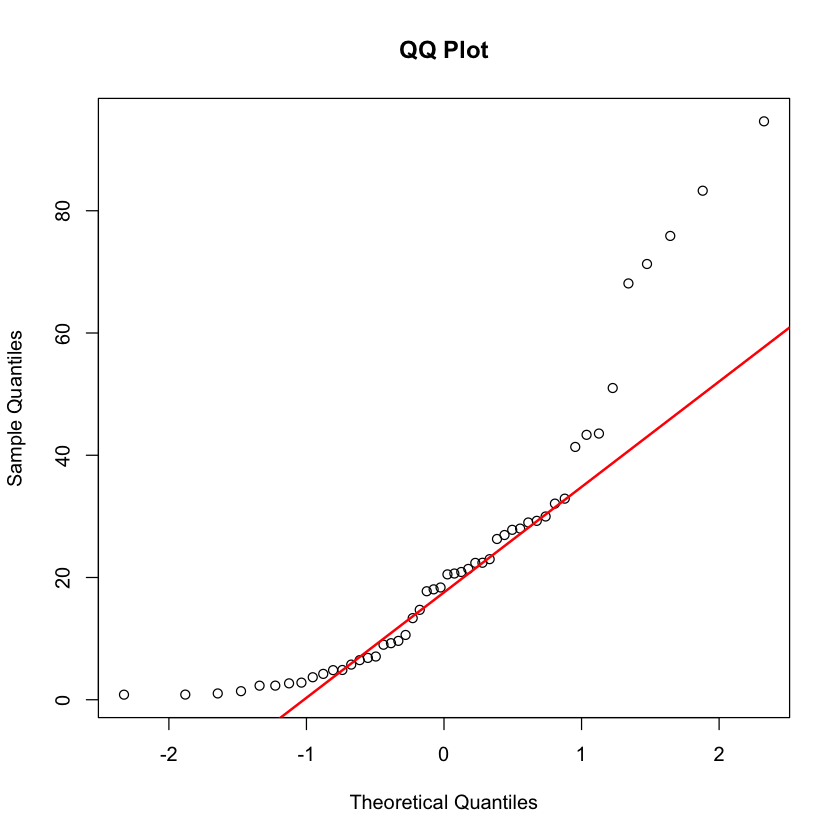

In [26]:
qqnorm(df$Open, main = "QQ Plot")
qqline(df$Open, col = "red", lwd = 2)

In [27]:
# Thực hiện kiểm định K-S cho cột Weight
ks_test_Weight <- ks.test(df$Open, "pnorm", mean=mean(df$Open), sd=sd(df$Open))

# Hiển thị kết quả kiểm định
print(ks_test_Weight)


	Exact one-sample Kolmogorov-Smirnov test

data:  df$Open
D = 0.1643, p-value = 0.1199
alternative hypothesis: two-sided



- Với p-value = 0.1199, chúng ta không có đủ bằng chứng để bác bỏ giả thuyết không rằng cột Open của DataFrame df tuân theo phân phối chuẩn ở mức ý nghĩa 0.05. Điều này có nghĩa là dữ liệu Open Price không khác biệt đáng kể so với phân phối chuẩn

In [28]:
mu_0 = 30.29
t_obs <- one_mean_test_diff(data = df$Open,
ind = c(1:12), mu_0 = mu_0)
t_obs

[1] -5.935833

In [29]:
mean <- mean(df$Open)
out_boot <- boot(data = df$Open,
statistic = one_mean_test_diff, R = 10000,
mu_0 = mean)
out_boot


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = df$Open, statistic = one_mean_test_diff, R = 10000, 
    mu_0 = mean)


Bootstrap Statistics :
    original      bias    std. error
t1*        0 -0.00911433    3.207347

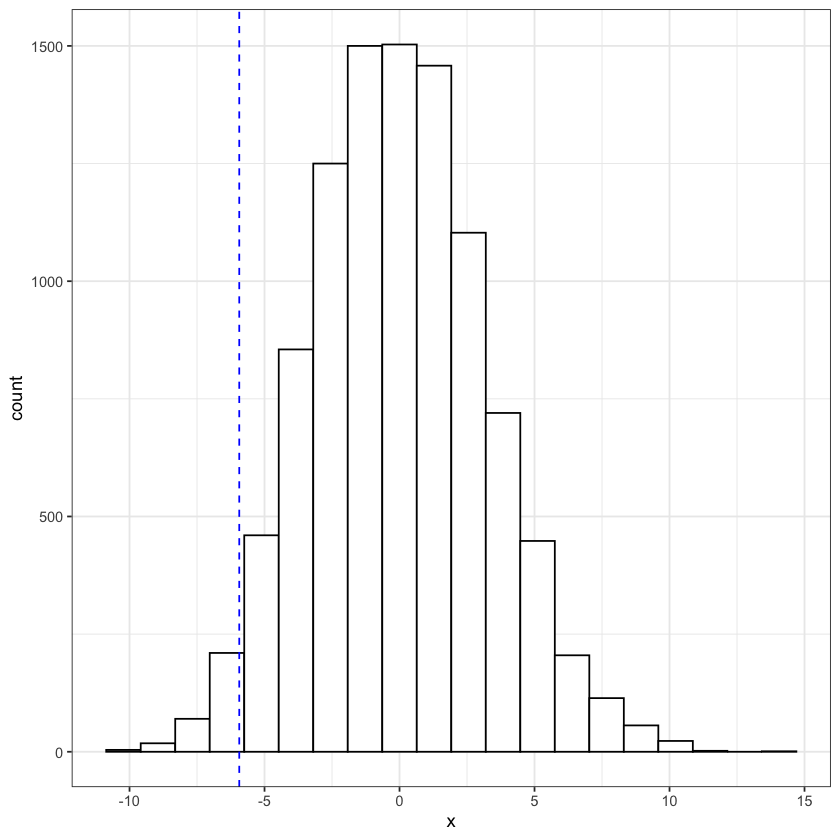

In [30]:
ggplot(data = data.frame(x = out_boot$t), mapping = aes(x = x)) +
geom_histogram(bins = 20, fill = "white", color = "black") +
geom_vline(xintercept = t_obs, linetype = "dashed", color = "blue") +
theme_bw()

In [31]:
p_value = mean(abs(out_boot$t) > abs(t_obs))
p_value

[1] 0.0623

- Với p-value = 0.0623 > mức ý nghĩa alpha = 0.05, ta không đủ bằng chứng để bác bỏ H0 rằng giá mở cửa = 30.29 USD, Điều này có nghĩa là không có đủ bằng chứng để kết luận rằng trung bình của dữ liệu khác với 30.29

In [32]:
# Thực hiện kiểm định t-test một mẫu
t_test_result <- t.test(df$Open, mu = 30.29)  # Kiểm định trung bình có khác 30.29 hay không

# Hiển thị kết quả kiểm định
print(t_test_result)


	One Sample t-test

data:  df$Open
t = -2.1769, df = 49, p-value = 0.03434
alternative hypothesis: true mean is not equal to 30.29
95 percent confidence interval:
 16.8341 29.7523
sample estimates:
mean of x 
  23.2932 



- Với p-value = 0.03434 < mức ý nghĩa alpha = 0.05, ta có bằng chứng để bác bỏ H0 rằng giá mở cửa = 30.29 USD, Điều này có nghĩa là giá mở cửa có thể khác với 30.29

- Vậy có sự khác biệt giữa kết quả kiểm định bootstrap và t-test:
    - Boostrap: Không bác bỏ H0 rằng trung bình giá mở cửa = 30.29
    - t-test: Bác bỏ H0 rằng trung bình giá mở cửa = 20.29 (có nghĩa là có thể khác 30.29)

## BÀI TẬP 4

In [33]:
df = read_csv_function(base_path = base_path, file_name = "TV.csv")
head(df)

,ID,Times,Cable
,<int>,<dbl>,<chr>
1,1,7.0,Basic
2,2,10.0,Basic
3,3,10.6,Basic
4,4,10.2,Basic
5,5,8.6,Basic
6,6,7.6,Basic


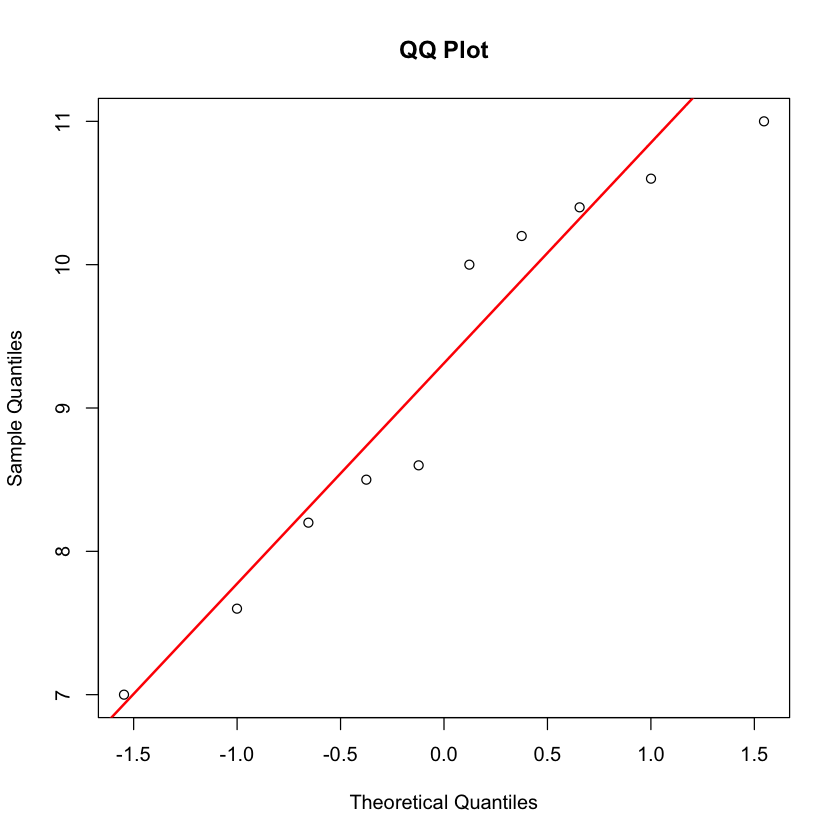

In [34]:
qqnorm(df$Times[df$Cable == "Basic"], main = "QQ Plot")
qqline(df$Times[df$Cable == "Basic"], col = "red", lwd = 2)

- QQ plot này cho thấy các điểm dữ liệu nằm gần đường thẳng 45 độ, cho thấy phân phối của mẫu tương đối gần với phân phối chuẩn. Tuy nhiên, có một số điểm lệch khỏi đường thẳng, đặc biệt ở phần đuôi, cho thấy sự khác biệt so với phân phối chuẩn. Tổng thể, phân bố mẫu có xu hướng tuân theo phân phối chuẩn nhưng vẫn có một số sai lệch nhỏ.

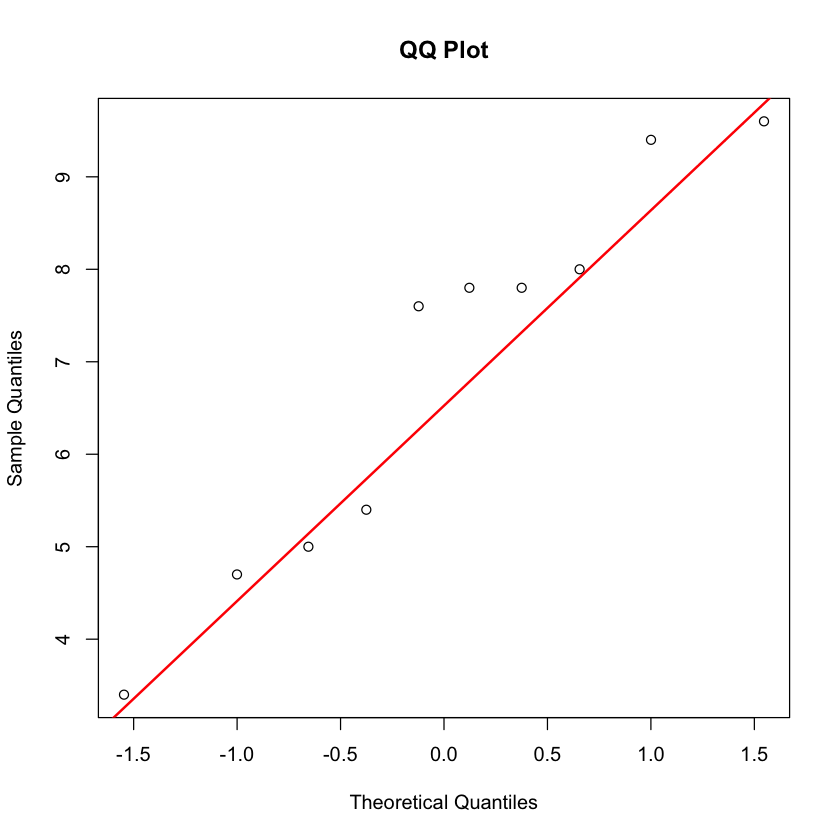

In [35]:
qqnorm(df$Times[df$Cable == "Extended"], main = "QQ Plot")
qqline(df$Times[df$Cable == "Extended"], col = "red", lwd = 2)

- QQ plot cho thấy các điểm dữ liệu chủ yếu nằm gần đường thẳng 45 độ, chỉ ra rằng phân bố của mẫu tương đối gần với phân bố chuẩn. Tuy nhiên, có một số điểm lệch khỏi đường thẳng, đặc biệt ở phần giữa của phân bố, cho thấy sự khác biệt nhỏ so với phân bố chuẩn. Tổng thể, phân bố mẫu có xu hướng tuân theo phân bố chuẩn nhưng có một số sai lệch nhỏ

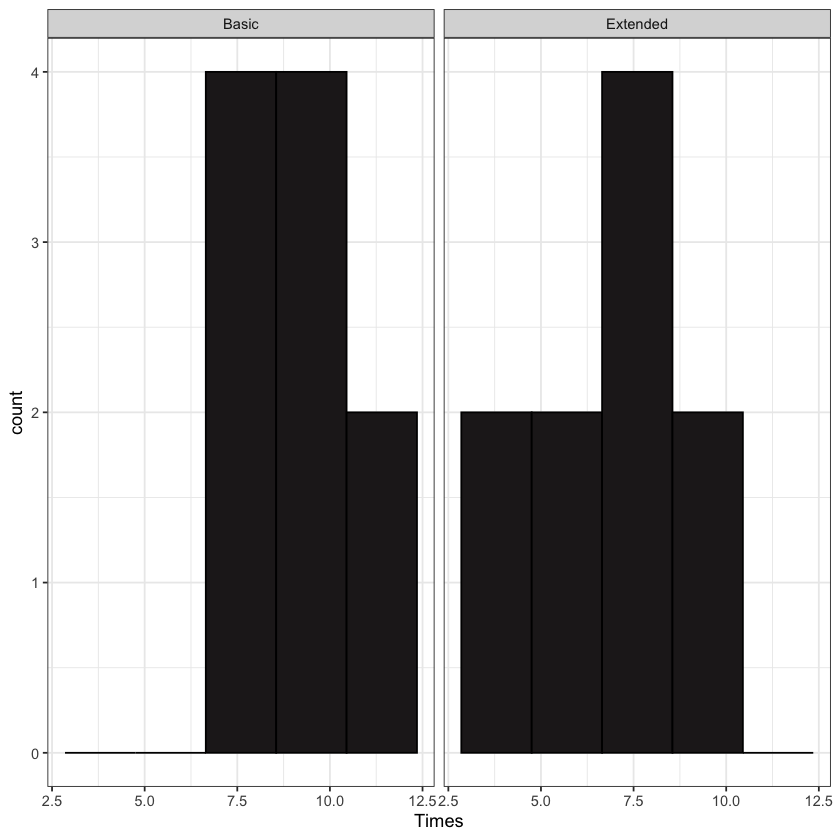

In [36]:
ggplot(df, mapping = aes(x = Times)) +
geom_histogram(bins = 5, fill = "#221f1f", color = "black") +
facet_grid(~ Cable) +
theme_bw()

In [37]:
sd(df$Times[df$Cable == "Extended"])/
sd(df$Times[df$Cable == "Basic"])

[1] 1.506844

- Tỷ số độ lệch chuẩn của hai nhóm nằm trong khoảng từ (0.5, 2). Do đó, giả định về đồng phương sai là hợp lý.

In [38]:
t_obs <- two_mean_test_diff_eqv(df$Times,
c(1:nrow(df)), n1 = 10, n2 = 10)
t_obs

[1] 2.34

In [39]:
out_boot <- boot(data = df$Times,
statistic = two_mean_test_diff_eqv, R = 10000,
n1 = 10, n2 = 10)
out_boot


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = df$Times, statistic = two_mean_test_diff_eqv, R = 10000, 
    n1 = 10, n2 = 10)


Bootstrap Statistics :
    original    bias    std. error
t1*     2.34 -2.352153   0.9044131

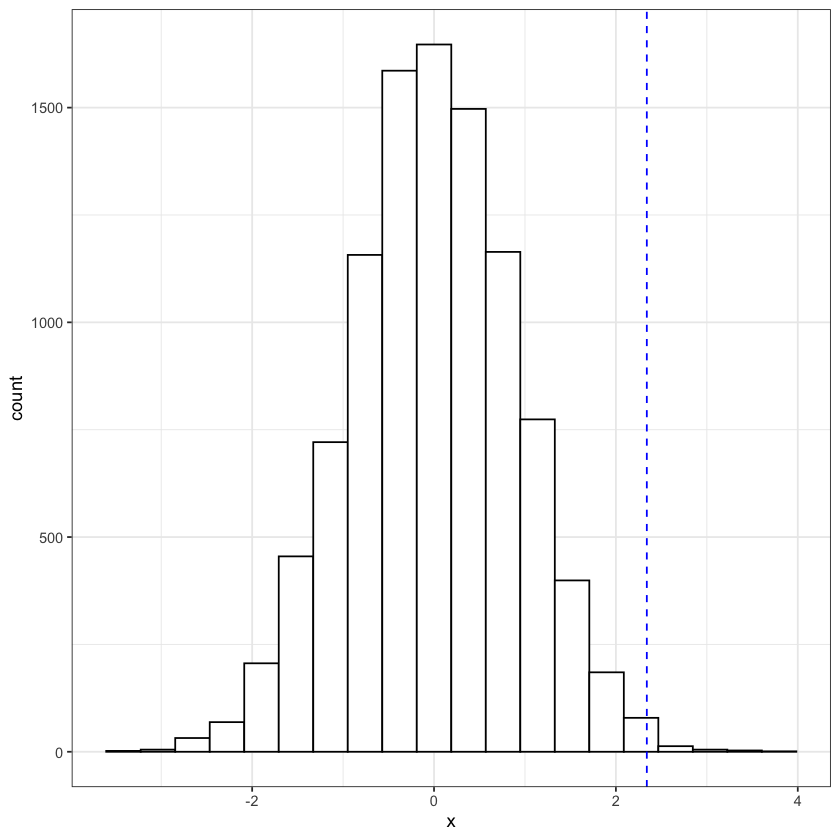

In [40]:
ggplot(data = data.frame(x = out_boot$t), mapping = aes(x = x)) +
geom_histogram(bins = 20, fill = "white", color = "black") +
geom_vline(xintercept = t_obs, linetype = "dashed", color = "blue") +
theme_bw()

In [41]:
mean(abs(out_boot$t) > abs(t_obs))

[1] 0.0092

- Với p-value = 0.0092 < mức ý nghĩa alpha = 0.05, ta có bằng chứng để bác bỏ H0 rằng thời lượng quảng cáo trên 2 kênh là như nhau, có nghĩa là có sự khác biệt về trung bình của thời lượng quảng cáo trên hai kênh

## BÀI TẬP 5

In [42]:
df = read_csv_function(base_path = base_path, file_name = "MathAnxiety.csv")
head(df)

,Age,Gender,Grade,AMAS,RCMAS,Arith
,<dbl>,<chr>,<chr>,<int>,<int>,<int>
1,137.8,Boy,Secondary,9,20,6
2,140.7,Boy,Secondary,18,8,6
3,137.9,Girl,Secondary,23,26,5
4,142.8,Girl,Secondary,19,18,7
5,135.6,Boy,Secondary,23,20,1
6,135.0,Girl,Secondary,27,33,1


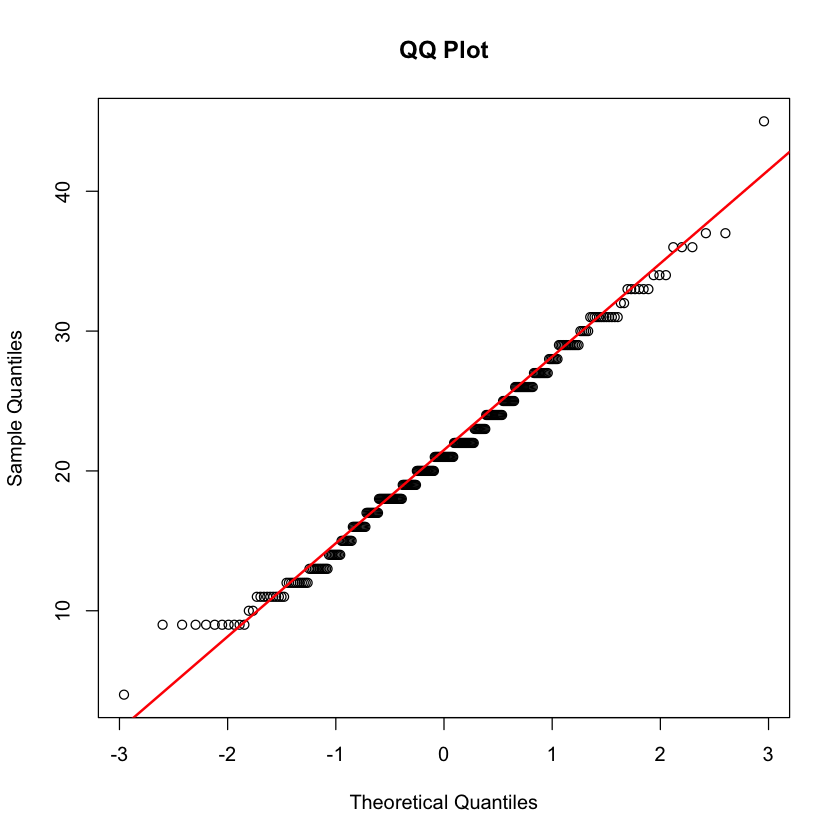

In [43]:
qqnorm(df$AMAS[df$Gender == "Boy"], main = "QQ Plot")
qqline(df$AMAS[df$Gender == "Boy"], col = "red", lwd = 2)

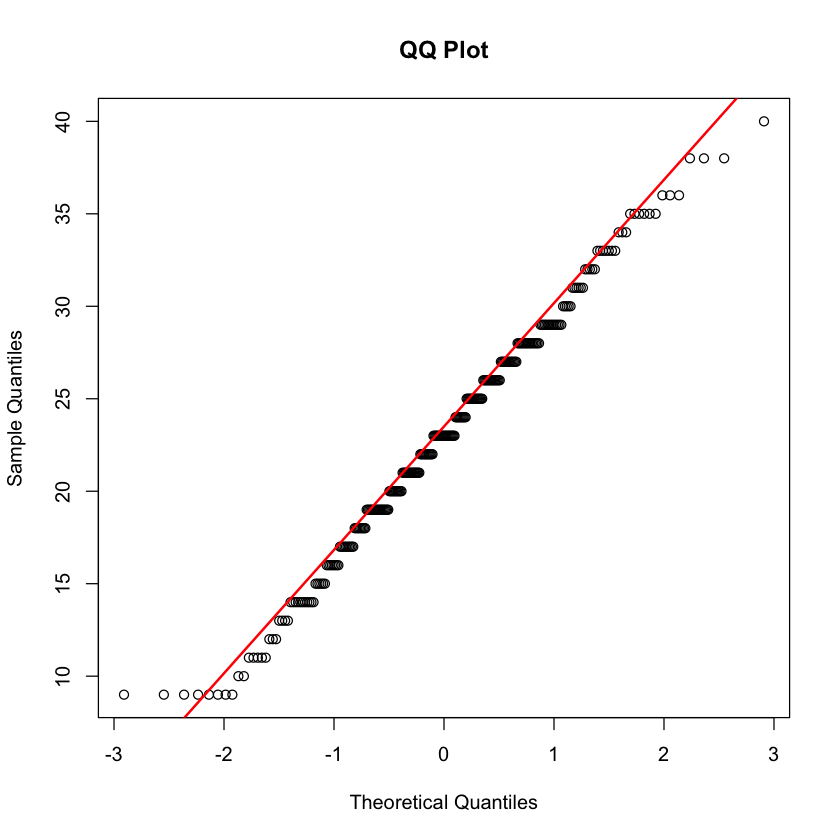

In [44]:
qqnorm(df$AMAS[df$Gender == "Girl"], main = "QQ Plot")
qqline(df$AMAS[df$Gender == "Girl"], col = "red", lwd = 2)

- Biểu đồ QQ cho thấy rằng dữ liệu mẫu có phân phối gần như chuẩn, đặc biệt là ở phần trung tâm của phân phối. Tuy nhiên, có thể có một số sai lệch ở các phần đuôi, cho thấy khả năng tồn tại các giá trị ngoại lai hoặc đuôi dày hơn so với phân phối chuẩn

In [45]:
# Thực hiện kiểm định K-S cho Gender == "Girl"
ks_test_Weight <- ks.test(df$AMAS[df$Gender == "Girl"], "pnorm",
mean=mean(df$AMAS[df$Gender == "Girl"]), sd=sd(df$AMAS[df$Gender == "Girl"]))

# Hiển thị kết quả kiểm định
print(ks_test_Weight)


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  df$AMAS[df$Gender == "Girl"]
D = 0.043804, p-value = 0.6647
alternative hypothesis: two-sided



In [46]:
# Thực hiện kiểm định K-S cho Gender == "Girl"
ks_test_Weight <- ks.test(df$AMAS[df$Gender == "Boy"], "pnorm",
mean=mean(df$AMAS[df$Gender == "Boy"]), sd=sd(df$AMAS[df$Gender == "Boy"]))

# Hiển thị kết quả kiểm định
print(ks_test_Weight)


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  df$AMAS[df$Gender == "Boy"]
D = 0.058981, p-value = 0.2111
alternative hypothesis: two-sided



- Cả 2 kết quả đều cho p-value > mức ý nghĩa alpha = 0.05, do đó ta  chưa có cơ sở để bác bỏ giả thiết phân bố của dữ liệu AMAS của Nam và Nữ tuân theo phân phối chuẩn. Do đó có khả năng phân bố của dữ liệu AMAS tuân theo phân phối chuẩn

In [47]:
df = df[order(df$Gender), ]
table(df$Gender)


 Boy Girl 
 323  276 

In [48]:
df |> group_by(Gender) |>
summarise(n = n(), mean = mean(AMAS), sd = sd(AMAS))

Gender,n,mean,sd
<chr>,<int>,<dbl>,<dbl>
Boy,323,21.16718,6.506321
Girl,276,22.93478,6.588372


In [49]:
sd(df$AMAS[df$Gender == "Boy"])/
sd(df$AMAS[df$Gender == "Girl"])

[1] 0.9875461

- Tỷ số độ lệch chuẩn của 2 nhóm = 0.98 ~1 do đó giả định về đồng phương sai là hợp lý

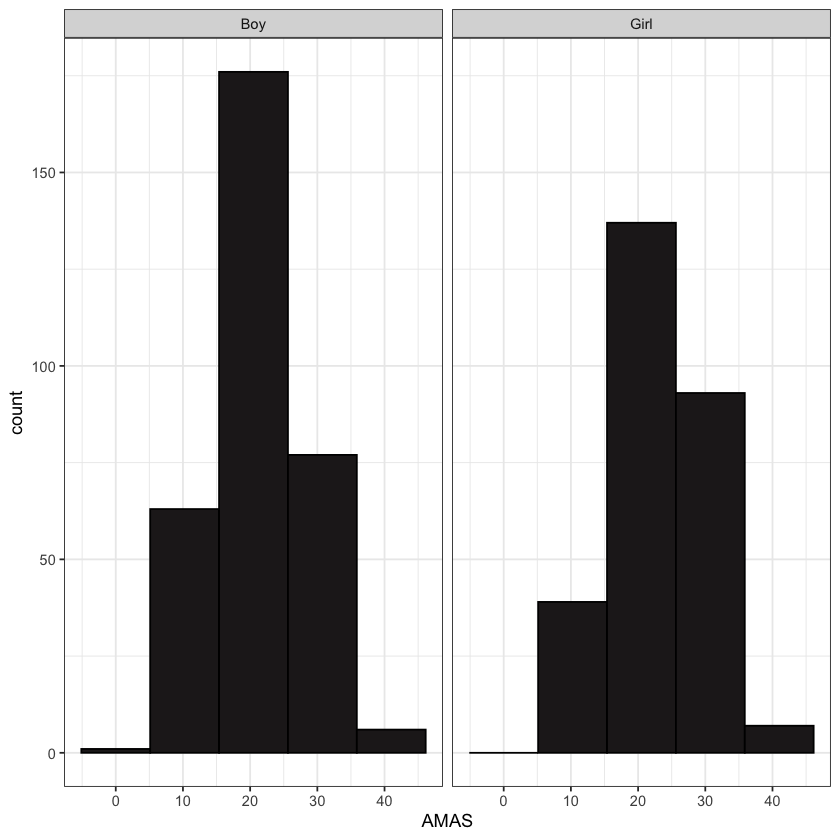

In [50]:
ggplot(df, mapping = aes(x = AMAS)) +
geom_histogram(bins = 5, fill = "#221f1f", color = "black") +
facet_grid(~ Gender) +
theme_bw()

In [51]:
t_obs <- two_mean_test_diff_eqv(df$AMAS,
c(1:nrow(df)), n1 = 323, n2 = 323)
t_obs

[1] -1.7676

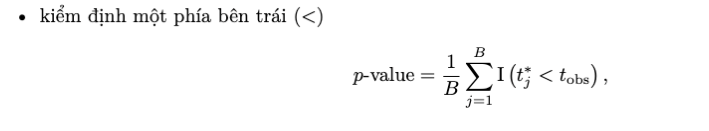

In [52]:
out_boot <- boot(data = df$AMAS,
statistic = two_mean_test_diff_eqv, R = 10000,
n1 = 323, n2 = 323)
out_boot


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = df$AMAS, statistic = two_mean_test_diff_eqv, R = 10000, 
    n1 = 323, n2 = 323)


Bootstrap Statistics :
    original   bias    std. error
t1*  -1.7676 1.765826   0.5467576

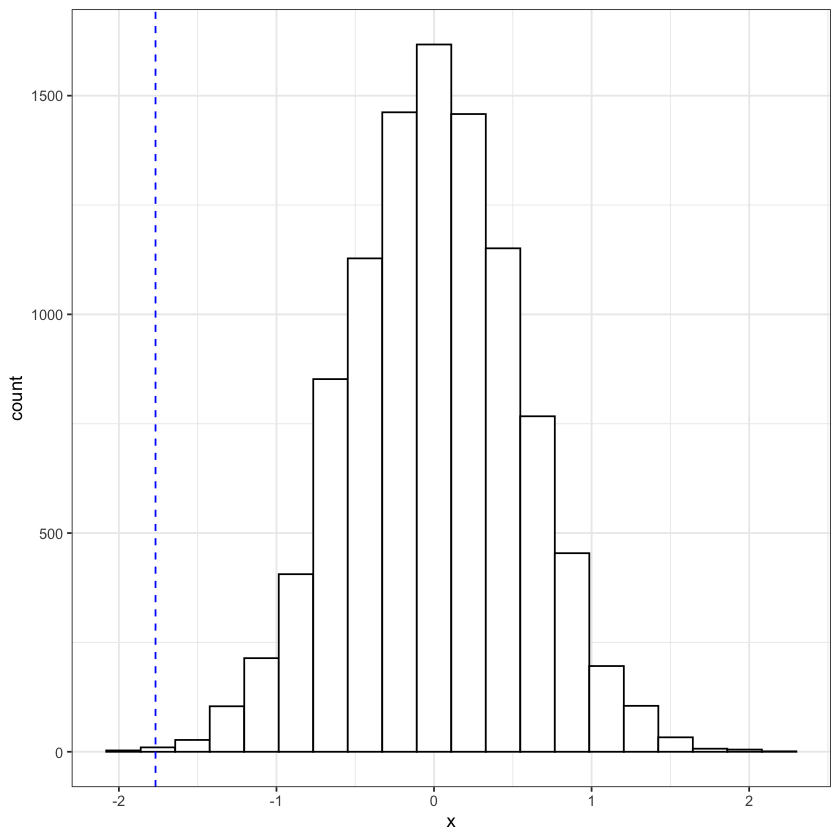

In [53]:
ggplot(data = data.frame(x = out_boot$t), mapping = aes(x = x)) +
geom_histogram(bins = 20, fill = "white", color = "black") +
geom_vline(xintercept = t_obs, linetype = "dashed", color = "blue") +
theme_bw()

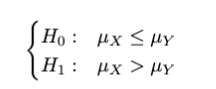

In [54]:
p_value = mean((out_boot$t) < (t_obs))
p_value

[1] 6e-04

- Với giá trị p-value = 6*10^-4 < alpha = 0.05 nên ta bác bỏ giả thiết H0 rằng sự lo lắng về mặt toán học ở học sinh nữ là cao hơn ở học sinh nam

## BÀI TẬP 6

In [55]:
df = read_csv_function(base_path = base_path, file_name = "IceCream.csv")
head(df)

,Brand,VanillaCalories,VanillaFat,VanillaSugar,ChocolateCalories,ChocolateFat,ChocolateSugar
,<chr>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,Baskin Robbins,260,16.0,26.0,260,14,31.0
2,Ben & Jerry's,240,16.0,19.0,260,16,22.0
3,Blue Bunny,140,7.0,12.0,130,7,14.0
4,Breyers,140,7.0,13.0,140,8,16.0
5,Brigham's,190,12.0,17.0,200,12,18.0
6,Bulla,234,13.5,21.8,266,15,22.6


In [56]:
summary(df$VanillaCalories)
summary(df$ChocolateCalories)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  120.0   140.0   160.0   191.4   240.0   307.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  120.0   140.0   170.0   198.7   260.0   320.0 

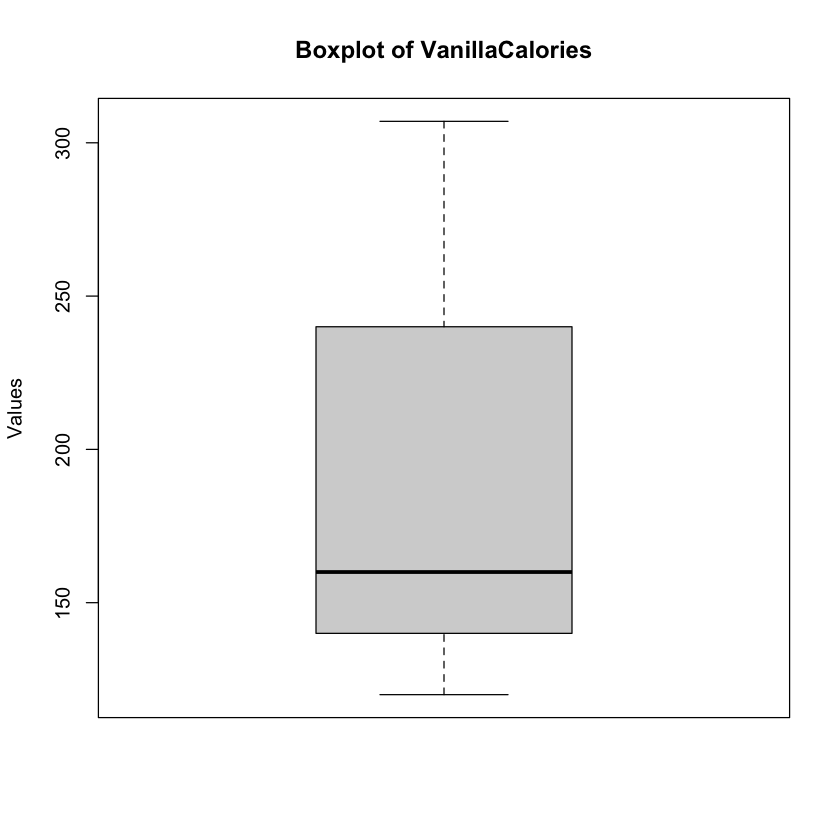

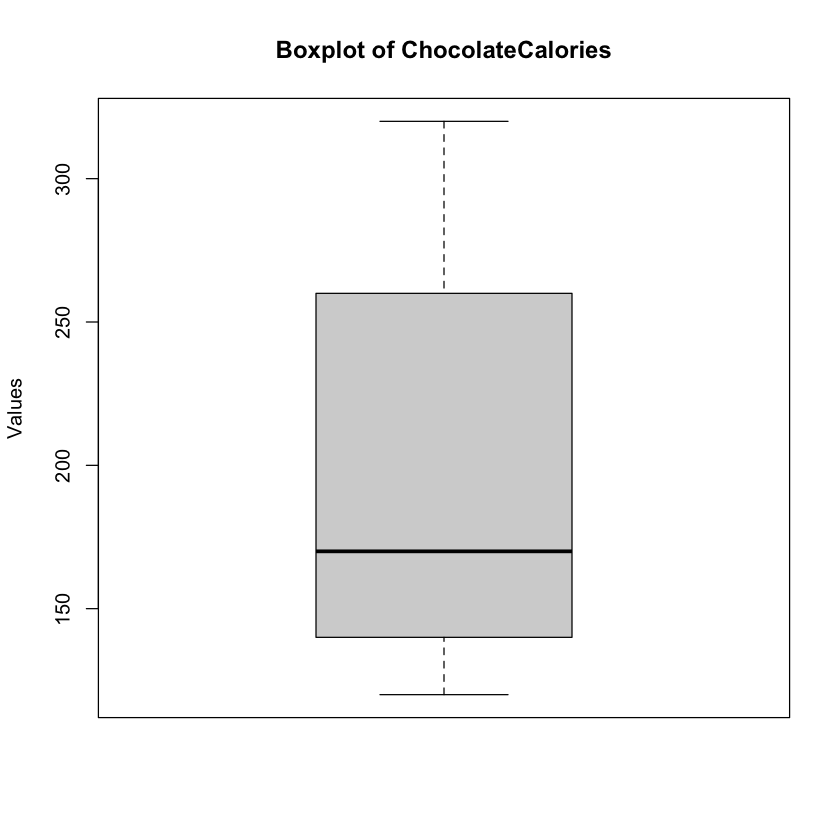

In [57]:
boxplot(df$VanillaCalories, main="Boxplot of VanillaCalories", ylab="Values")
boxplot(df$ChocolateCalories, main="Boxplot of ChocolateCalories", ylab="Values")

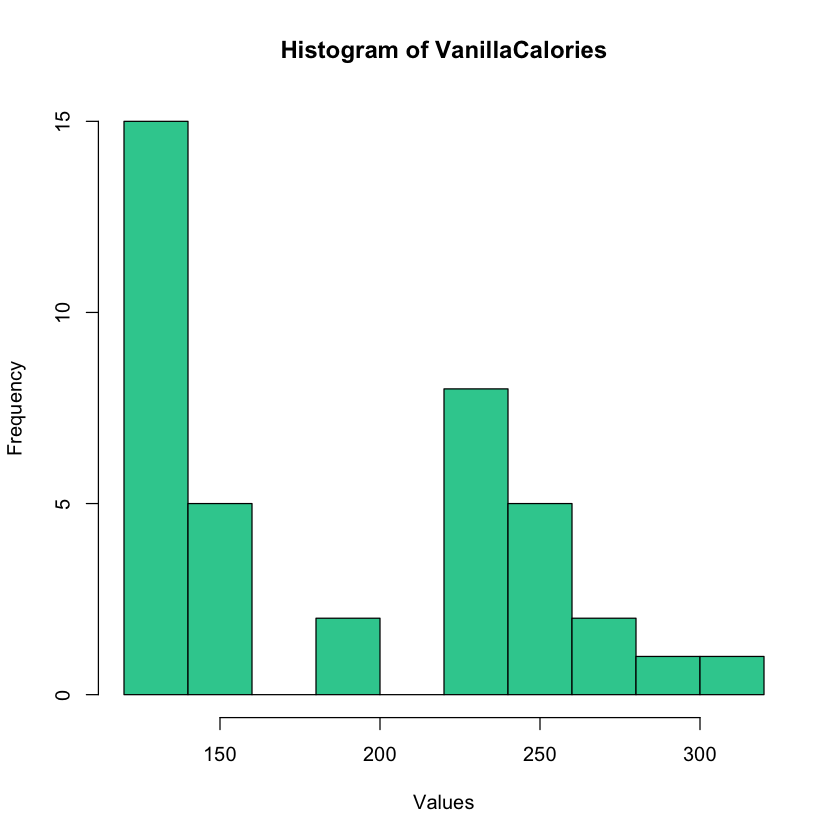

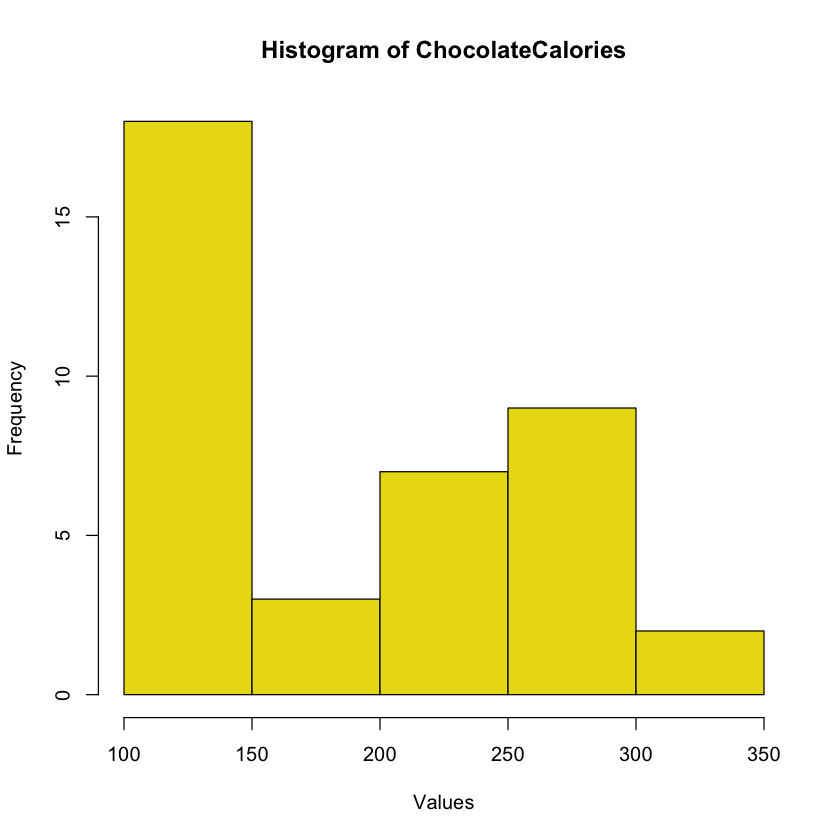

In [58]:
hist(df$VanillaCalories, main="Histogram of VanillaCalories", xlab="Values", ylab="Frequency", col="#32cd9e", border="black")
hist(df$ChocolateCalories, main="Histogram of ChocolateCalories", xlab="Values", ylab="Frequency", col="#eadb15", border="black")

In [59]:
df_new <- data.frame(value = c(df$VanillaCalories, df$ChocolateCalories), 
                     type = rep(c("VanillaCalories", "ChocolateCalories"), each = nrow(df)))

In [60]:
df_new |> group_by(type) |>
summarise(n = n(), mean = mean(value), sd = sd(value))

type,n,mean,sd
<chr>,<int>,<dbl>,<dbl>
ChocolateCalories,39,198.7436,63.06334
VanillaCalories,39,191.4103,58.64421


In [61]:
sd(df_new$value[df_new$type == "ChocolateCalories"])/
sd(df_new$value[df_new$type == "VanillaCalories"])

[1] 1.075355

- Đồng phương sai

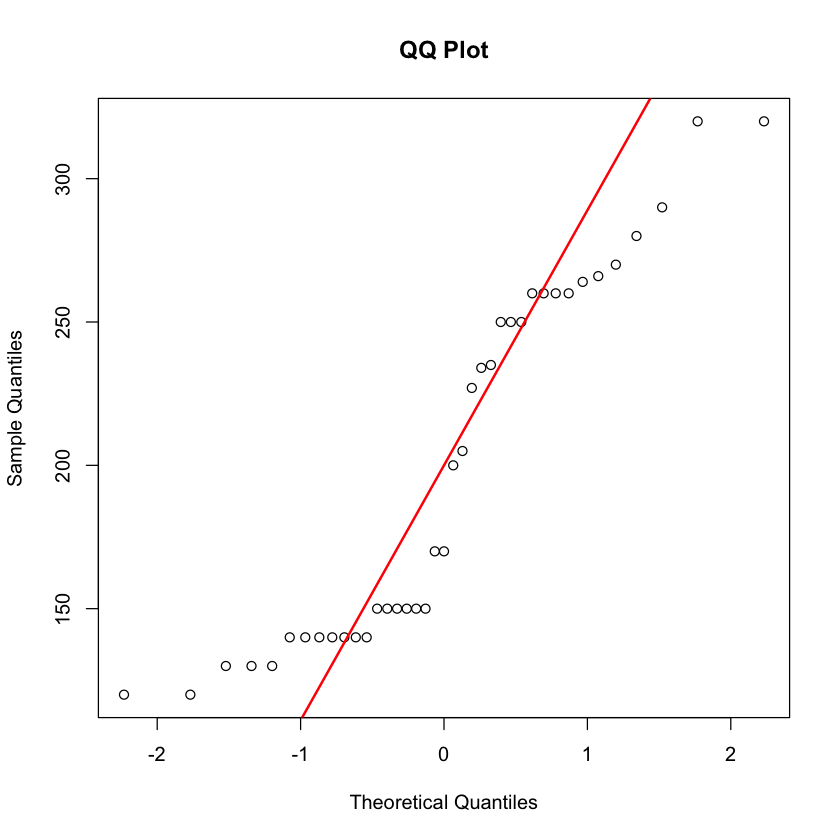

In [62]:
qqnorm(df_new$value[df_new$type == "ChocolateCalories"], main = "QQ Plot")
qqline(df_new$value[df_new$type == "ChocolateCalories"], col = "red", lwd = 2)

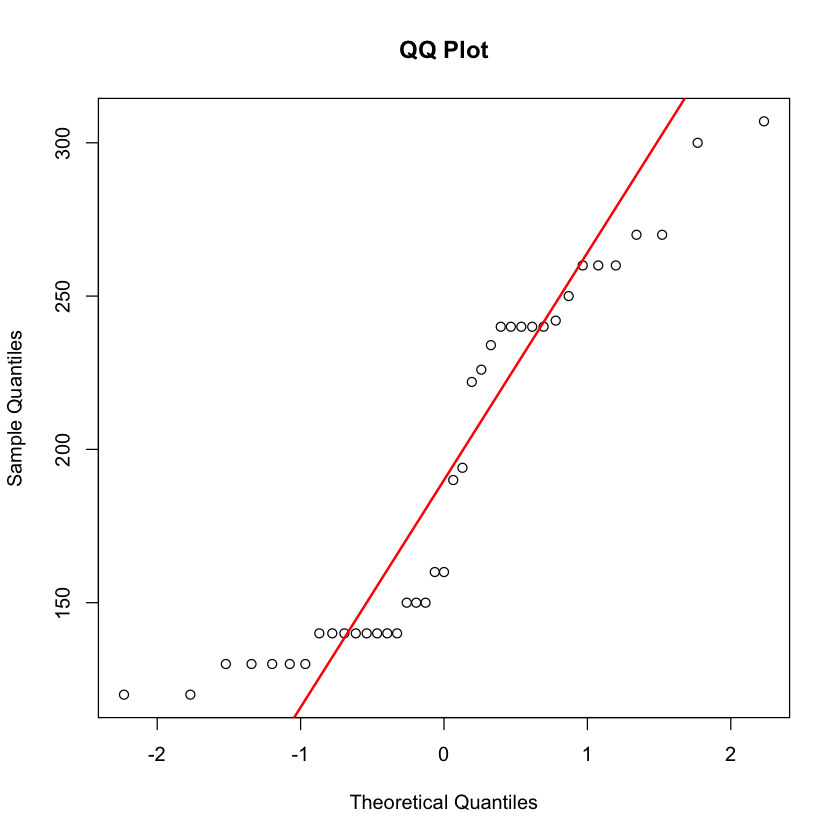

In [63]:
qqnorm(df_new$value[df_new$type == "VanillaCalories"], main = "QQ Plot")
qqline(df_new$value[df_new$type == "VanillaCalories"], col = "red", lwd = 2)

In [64]:
t_obs <- two_mean_test_diff_eqv(df_new$value,
c(1:nrow(df_new)), n1 = 39, n2 = 39)
t_obs

[1] -7.333333

In [65]:
out_boot <- boot(data = df_new$value,
statistic = two_mean_test_diff_eqv, R = 10000,
n1 = 39, n2 = 39)
out_boot


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = df_new$value, statistic = two_mean_test_diff_eqv, 
    R = 10000, n1 = 39, n2 = 39)


Bootstrap Statistics :
     original   bias    std. error
t1* -7.333333 7.378479    13.57201

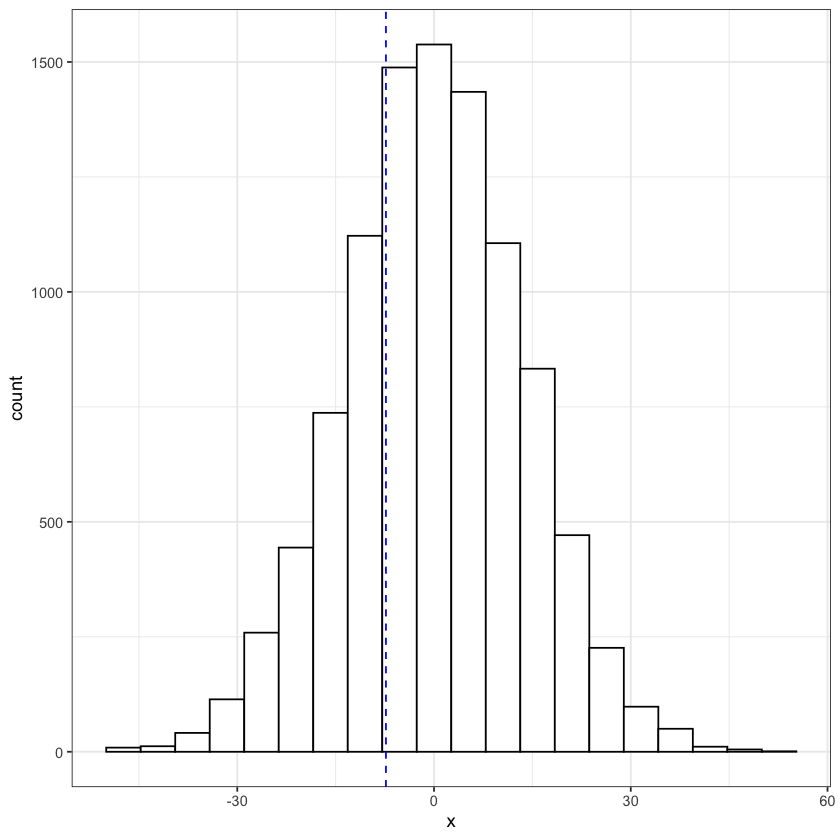

In [66]:
ggplot(data = data.frame(x = out_boot$t), mapping = aes(x = x)) +
geom_histogram(bins = 20, fill = "white", color = "black") +
geom_vline(xintercept = t_obs, linetype = "dashed", color = "blue") +
theme_bw()

In [67]:
p_value = mean((out_boot$t) > abs(t_obs))
p_value

[1] 0.2929

- p-value = 0.2929 > alpha = 0.05, do đó ta có bằng chứng để bác bỏ H0 rằng trung bình lượng calo của hai loại kem là bằng nhau, hay nói cách khác là có sự khác biệt về trung bình lượng calo giữa hai loại kem

## BÀI TẬP 7

In [68]:
df = read_csv_function(base_path = base_path, file_name = "Illiteracy.csv")
head(df)

,ID,Country,Illit,Births
,<int>,<chr>,<dbl>,<dbl>
1,1,Albania,20.5,1.78
2,2,Algeria,39.1,2.44
3,3,Bahrain,15.0,2.34
4,4,Belize,5.9,2.97
5,5,Benin,73.5,5.60
6,6,Bolivia,18.5,3.65


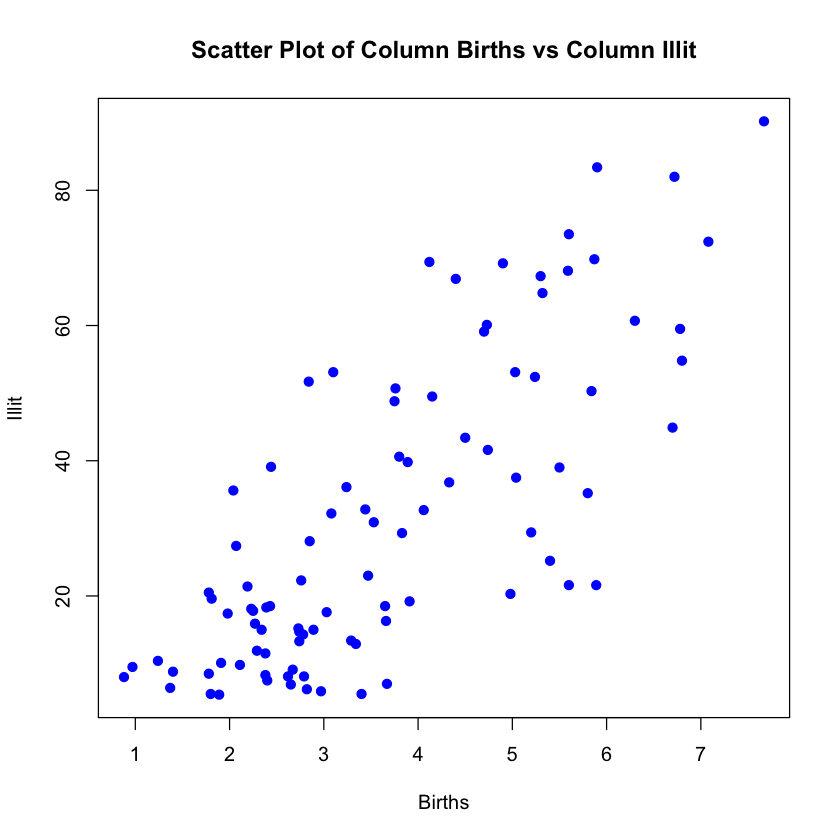

In [69]:
# Vẽ biểu đồ phân tán của cột a so với cột b
plot(df$Births, df$Illit, main="Scatter Plot of Column Births vs Column Illit", xlab="Births", ylab="Illit", pch=19, col="blue")

- Nhìn tổng thể, có thể có một mối tương quan tuyến tính giữa hai biến, hai biến có một xu hướng tăng lên, tức là khi số lượng sinh tăng, tỉ lệ mù chữ cũng có xu hướng tăng theo

In [70]:
# Tính hệ số tương quan Pearson
correlation <- cor(df$Births, df$Illit, method = "pearson")
correlation

[1] 0.768663

In [71]:
fun_corr_test <- function(data, ind) {
data <- data[ind,]
n_data <- nrow(data)/2
x_b <- data[1:n_data, 1]
y_b <- data[(n_data + 1):(2 * n_data), 1]
r_est <- cor(x = x_b, y = y_b)
return(r_est)
}

In [72]:
n <- nrow(df)
df_new <- data.frame(val = c(df$Births, df$Illit),
type = factor(rep(c("Births", "Illit"),
c(n, n)),
levels = c("Births", "Illit")))
head(df_new)

,val,type
,<dbl>,<fct>
1,1.78,Births
2,2.44,Births
3,2.34,Births
4,2.97,Births
5,5.60,Births
6,3.65,Births


In [73]:
set.seed(226)
out_boot <- boot(data = df_new, statistic = fun_corr_test,
R = 10000, sim = "ordinary", stype = "i",
strata = df_new$type)

In [74]:
out_boot


STRATIFIED BOOTSTRAP


Call:
boot(data = df_new, statistic = fun_corr_test, R = 10000, sim = "ordinary", 
    stype = "i", strata = df_new$type)


Bootstrap Statistics :
    original     bias    std. error
t1* 0.768663 -0.7704239   0.1035845

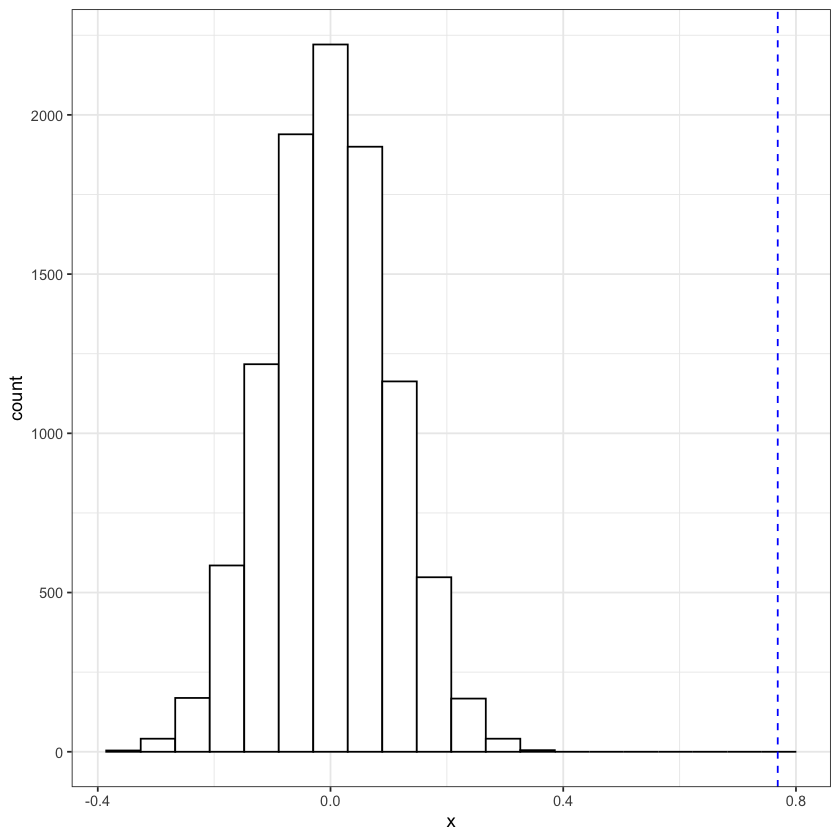

In [75]:
ggplot(data = data.frame(x = out_boot$t), mapping = aes(x = x)) +
geom_histogram(bins = 20, fill = "white", color = "black") +
geom_vline(xintercept = correlation, linetype = "dashed", color = "blue") +
theme_bw()

In [76]:
p_value = mean(abs(out_boot$t) >= correlation)
p_value

[1] 0

- p-value = 0 < alpha = 0.05, Như vậy, sự tương quan tuyến tính giữa Births và Illit là có ý nghĩa thống kê, tại mức ý nghĩa 5%

## BÀI TẬP 8

In [77]:
df = read_csv_function(base_path = base_path, file_name = "Phillies2009.csv")
head(df)

,Date,Location,Outcome,Hits,Doubles,Homeruns,StrikeOuts
,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>
1,5-Apr,Home,Lose,4,2,0,6
2,7-Apr,Home,Lose,6,1,0,3
3,8-Apr,Home,Win,11,3,1,6
4,10-Apr,Away,Lose,7,2,1,3
5,11-Apr,Away,Win,15,3,1,6
6,12-Apr,Away,Win,13,3,2,4


In [78]:
# wall_eye <- read_csv(file = "datasets/Walleye.csv")
df <- df |> janitor::clean_names()
glimpse(df)

Rows: 162
Columns: 7
$ date        <chr> "5-Apr", "7-Apr", "8-Apr", "10-Apr", "11-Apr", "12-Apr", "~
$ location    <chr> "Home", "Home", "Home", "Away", "Away", "Away", "Away", "A~
$ outcome     <chr> "Lose", "Lose", "Win", "Lose", "Win", "Win", "Win", "Lose"~
$ hits        <int> 4, 6, 11, 7, 15, 13, 10, 5, 14, 8, 9, 13, 8, 2, 8, 9, 12, ~
$ doubles     <int> 2, 1, 3, 2, 3, 3, 3, 1, 3, 2, 1, 4, 0, 0, 2, 0, 2, 5, 0, 0~
$ homeruns    <int> 0, 0, 1, 1, 1, 2, 3, 0, 1, 3, 3, 1, 1, 1, 2, 2, 0, 2, 4, 1~
$ strike_outs <int> 6, 3, 6, 3, 6, 4, 7, 3, 5, 7, 5, 8, 4, 4, 12, 8, 7, 7, 5, ~


In [79]:
ks_fun <- function(z, n) {
fn_z <- c(1:n)/n
res <- max(c(fn_z - z, z - (fn_z - 1/n)))
return(res)
}

In [80]:
cvm_fun <- function(z, n) {
fn_z <- (2 * c(1:n) - 1)/(2 * n)
res <- sum((z - fn_z)^2) + 1/(12 * n)
return(res)
}

In [81]:
gof_ks_stat_pois <- function(data) {
x_new <- sort(data)
n <- length(data)
fn_x_pois <- pnorm(x_new, mean = mean(x_new), sd = sd(x_new))
ks_stat <- ks_fun(fn_x_pois, n = n)
return(ks_stat)
}

In [82]:
ran_gen_pois <- function(data, mle) {
  return(rpois(length(data), lambda = mle))
}

In [83]:
test_ks_stat <- gof_ks_stat_pois(df$doubles)
test_ks_stat

[1] 0.1703774

In [84]:
# Quá trình bootstrap Kolmogorov-Smirnov kiểm tra giả định phân phối Poision
mean_doubles <- mean(df$doubles)
sd_doubles <- sd(df$doubles)
set.seed(286)
out_ks_boot <- boot(data = df$doubles, statistic = gof_ks_stat_pois,
R = 10000, sim = "parametric", ran.gen = ran_gen_pois,
mle = c(mean_doubles, sd_doubles))
out_ks_boot


PARAMETRIC BOOTSTRAP


Call:
boot(data = df$doubles, statistic = gof_ks_stat_pois, R = 10000, 
    sim = "parametric", ran.gen = ran_gen_pois, mle = c(mean_doubles, 
        sd_doubles))


Bootstrap Statistics :
     original     bias    std. error
t1* 0.1703774 0.03320577  0.01970216

In [85]:
p_value = mean(out_ks_boot$t > test_ks_stat)
p_value

[1] 0.9647

- p-value = 0.9647 > alpha = 0.05: bác bỏ giả thiết H0 rằng phân phối tuân theo phân phối poision

### BÀI TẬP 9

In [86]:
df <- data.frame(
  X = c(0, 1, 2, 3, 4),
  tan_so = c(80, 40, 22, 15, 10)
)
df

X,tan_so
<dbl>,<dbl>
0,80
1,40
2,22
3,15
4,10


## BÀI TẬP 10